Importing Libraries

In [43]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.morphology import binary_opening
import numpy as np
import cv2

/var/folders/mm/zm2c4z0n06b2tq4zt0hs6sfc0000gn/T/ipykernel_92216/1796674642.py:4: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_closing
/var/folders/mm/zm2c4z0n06b2tq4zt0hs6sfc0000gn/T/ipykernel_92216/1796674642.py:5: DeprecationWarning: Please use `binary_opening` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_opening


Loading the data

In [91]:
mat = loadmat('data/example1kinect.mat',  mdict=None, appendmat=True)
# mat = loadmat('data/example2kinect.mat',  mdict=None, appendmat=True)
# mat = loadmat('data/example3kinect.mat',  mdict=None, appendmat=True)
# mat = loadmat('data/example4kinect.mat',  mdict=None, appendmat=True)
# mat = loadmat('data/example4kinect_corrected.mat',  mdict=None, appendmat=True)
print(mat.keys())
keys = list(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'amplitudes1', 'distances1', 'cloud1'])


In [94]:
amplitude = mat[keys[3]]
normalized_image = cv2.normalize(amplitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
grayscale_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2GRAY)
ret,thresh1 = cv2.threshold(normalized_image,20,255,cv2.THRESH_BINARY)
closed_image = binary_closing(thresh1, iterations=2)
opened_image = binary_opening(closed_image, iterations=2)
print(normalized_image)

error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


Showing amplitude image

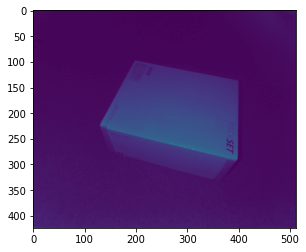

In [40]:
amplitude = mat[keys[3]]
plt.imshow(amplitude)

Showing distance image

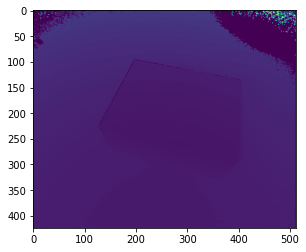

In [41]:
distance = mat[keys[4]]
plt.imshow(distance)

Showing cloud image

In [ ]:
cloud = mat[keys[5]]
# plt.imshow(cloud)

3D plot of Point Cloud

In [ ]:
num_rows, num_cols, num_xyz = cloud.shape

# Reshape the cloud values array to flatten the (x, y, z) coordinates
cloud_values_flat = cloud.reshape((num_rows * num_cols, num_xyz))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(cloud_values_flat[:, 0], cloud_values_flat[:, 1], cloud_values_flat[:, 2], zdir='z')

plt.show()